In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('sales_data_sample.csv', encoding='unicode_escape')
df.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [4]:
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE',
'PHONE']
df = df.drop(to_drop, axis=1)

In [5]:
df.isnull().sum()


ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [6]:
df.dtypes


ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [7]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [9]:
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days=1)
df_RFM = df.groupby('CUSTOMERNAME').agg({
 'ORDERDATE': lambda x: (snapshot_date - x.max()).days,
 'ORDERNUMBER': 'count',
 'SALES': 'sum'
})


In [10]:
df_RFM.rename(columns={
 'ORDERDATE': 'Recency',
 'ORDERNUMBER': 'Frequency',
 'SALES': 'MonetaryValue'
}, inplace=True)

In [11]:
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q=4, labels=range(1,5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q=4, labels=list(range(4,0,-
1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q=4, labels=range(1,5))
df_RFM.head()


,Recency,Frequency,MonetaryValue,M,R,F
CUSTOMERNAME,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4
Alpha Cognac,65,20,70488.44,2,4,2
Amica Models & Co.,265,26,94117.26,3,1,2
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4
Atelier graphique,188,7,24179.96,1,2,1


In [12]:
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)

In [16]:

def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'High Value Customer'
    elif 6 <= df['RFM_Score'] < 10:
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'


In [17]:
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)
print(df_RFM.head())

                         Recency  Frequency  MonetaryValue  M  R  F  \
CUSTOMERNAME                                                          
AV Stores, Co.               196         51      157807.81  4  2  4   
Alpha Cognac                  65         20       70488.44  2  4  2   
Amica Models & Co.           265         26       94117.26  3  1  2   
Anna's Decorations, Ltd       84         46      153996.13  4  3  4   
Atelier graphique            188          7       24179.96  1  2  1   

                         RFM_Score            RFM_Level  
CUSTOMERNAME                                             
AV Stores, Co.                  10  High Value Customer  
Alpha Cognac                     8   Mid Value Customer  
Amica Models & Co.               6   Mid Value Customer  
Anna's Decorations, Ltd         11  High Value Customer  
Atelier graphique                4   Low Value Customer  


In [19]:
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]

In [20]:
data_log = np.log1p(data)

In [21]:
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_log),
 index=data_log.index,
 columns=data_log.columns)
print(data_normalized.describe().round(2))


       Recency  Frequency  MonetaryValue
count    92.00      92.00          92.00
mean      0.00       0.00           0.00
std       1.01       1.01           1.01
min      -3.26      -3.41          -3.82
25%      -0.29      -0.43          -0.39
50%       0.37       0.05          -0.04
75%       0.54       0.44           0.52
max       1.18       4.16           3.92


In [22]:
data_log = np.log(data)
data_log.head()


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [24]:
sse = {}


In [26]:
for k in range(1, 21):
 kmeans = KMeans(n_clusters = k, random_state = 1)
 kmeans.fit(data_normalized)
 sse[k] = kmeans.inertia_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

Text(0.5, 1.0, 'The Elbow Method')

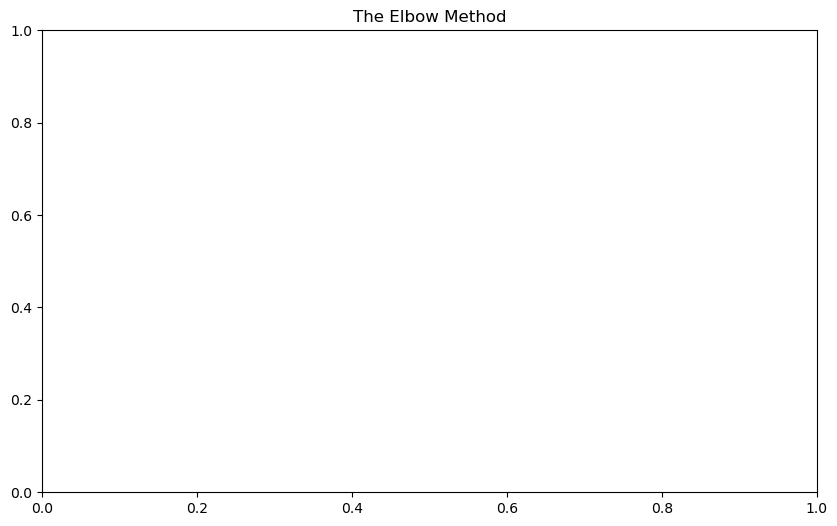

In [27]:
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')

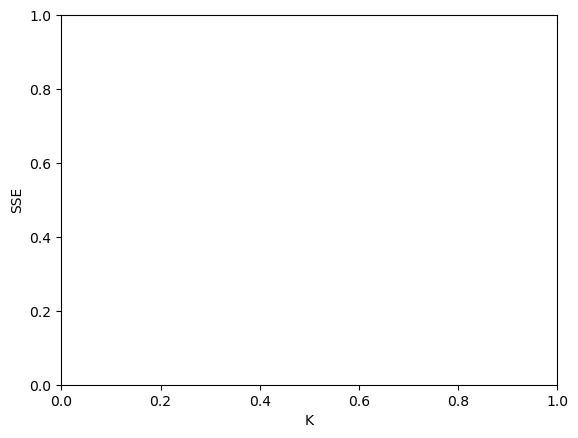

In [28]:
plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

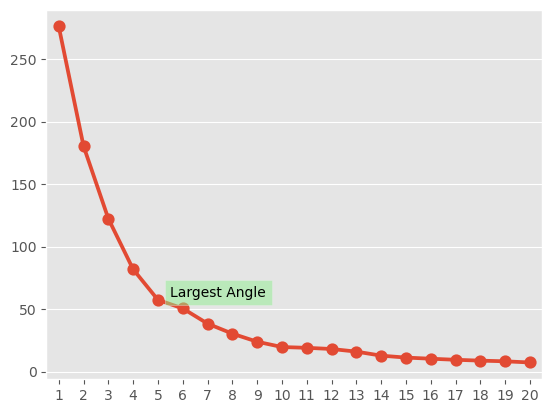

In [29]:
sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox = dict(facecolor =
'lightgreen', alpha = 0.5))
plt.show()


In [30]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm = data.assign(Cluster = cluster_labels)
data_rfm.head()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,4
Alpha Cognac,65,20,70488.44,2
Amica Models & Co.,265,26,94117.26,2
"Anna's Decorations, Ltd",84,46,153996.13,4
Atelier graphique,188,7,24179.96,1
